In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import joblib
from sklearn.linear_model import LinearRegression

In [ ]:
train = pd.read_excel("training.xlsx", na_values="(null)")
valid = pd.read_excel("validation.xlsx", na_values="(null)")

# checking data quality
print(train.isnull().sum())
print(valid.isnull().sum())
print(train['Route'].count())
print(valid['Route'].count())

In [4]:
# fixing the dataset, actualTOW is our main measure so we cannot just use aprox of it
train = train.rename(columns={"FLownPassengers": "FlownPassengers"})
valid = valid.rename(columns={"FLownPassengers": "FlownPassengers"})

train = train.dropna(subset=["ActualTOW"])

In [7]:
# mean for the connections with historical data, global mean for all the others
global_mean = round(train["FlownPassengers"].mean())


def passengers_filling(row):
    if pd.notnull(row["FlownPassengers"]):
        return row["FlownPassengers"]

    subset = train[
            (train["DepartureAirport"] == row["DepartureAirport"]) &
            (train["ArrivalAirport"] == row["ArrivalAirport"]) &
            (train["FlownPassengers"].notnull())
                    ]["FlownPassengers"]

    if len(subset) == 0:
        return global_mean

    return round(subset.mean())

train["FlownPassengers"] = train.apply(passengers_filling, axis=1)

In [8]:
# creating data to fill nulls
avg_bag_weight = train["FlightBagsWeight"].sum() / train["BagsCount"].sum()
print(avg_bag_weight)

avg_bag_count_per_passenger = train.loc[train["BagsCount"].notnull(), "BagsCount"].sum() / train.loc[train["BagsCount"].notnull(), "FlownPassengers"].sum()

print(avg_bag_count_per_passenger)

12.54126762796408
0.27114484948571244


In [9]:
# filling the nulls with estimations - might be a better idea to just remove that data, since some of them are with unusual routes (e.g. destination and departure airports are the same one, like PIK-PIK)
train.loc[train["BagsCount"].isnull(), "BagsCount"] = (
    train.loc[train["BagsCount"].isnull(), "FlownPassengers"] * avg_bag_count_per_passenger).round()

train.loc[train["FlightBagsWeight"].isnull(), "FlightBagsWeight"] = (
    train.loc[train["FlightBagsWeight"].isnull(), "BagsCount"] * avg_bag_weight
).round()


In [14]:
print(train.isnull().sum())
print(valid.isnull().sum())

DepartureDate       0
DepartureYear       0
DepartureMonth      0
DepartureDay        0
FlightNumber        0
DepartureAirport    0
ArrivalAirport      0
Route               0
ActualFlightTime    0
ActualTotalFuel     0
ActualTOW           0
FlownPassengers     0
BagsCount           0
FlightBagsWeight    0
dtype: int64
DepartureDate       0
DepartureYear       0
DepartureMonth      0
DepartureDay        0
FlightNumber        0
DepartureAirport    0
ArrivalAirport      0
Route               0
ActualFlightTime    0
ActualTotalFuel     0
FlownPassengers     9
BagsCount           9
FlightBagsWeight    9
dtype: int64


In [13]:
# filling the nulls - same as in the train dataset
valid.loc[valid["BagsCount"].isnull(), "BagsCount"] = (
    valid.loc[valid["BagsCount"].isnull(), "FlownPassengers"] * avg_bag_count_per_passenger
).round()

valid.loc[valid["FlightBagsWeight"].isnull(), "FlightBagsWeight"] = (
    valid.loc[valid["FlightBagsWeight"].isnull(), "BagsCount"] * avg_bag_weight
).round()

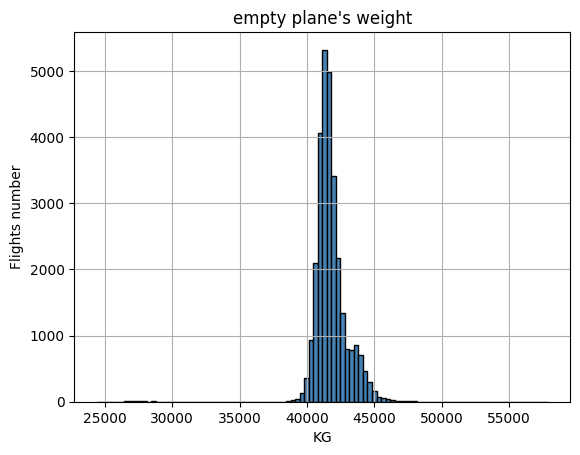

In [17]:
# empty plane should weight about ~41 000 kg
import matplotlib.pyplot as plt

train["ActualTOW"] = pd.to_numeric(train["ActualTOW"], errors='coerce')
train["ActualTotalFuel"] = pd.to_numeric(train["ActualTotalFuel"], errors='coerce')
train["FlightBagsWeight"] = pd.to_numeric(train["FlightBagsWeight"], errors='coerce')
train["FlownPassengers"] = pd.to_numeric(train["FlownPassengers"], errors='coerce')

train["EmptyPlane"] = train["ActualTOW"] - train["ActualTotalFuel"] - train["FlightBagsWeight"] - ((train["FlownPassengers"]+5) * 94) - 300 - 1400
# weight of an empty plane = weight - fuel burnt - luggage weight - ((passengers + crew) * (ESA weight + personal baggage)) - additional fuel - extras (catering etc.)

plt.hist(train["EmptyPlane"].dropna(), bins=100, color='steelblue', edgecolor='black')
plt.title("empty plane's weight")
plt.xlabel("KG")
plt.ylabel("Flights number")
plt.grid(True)
plt.show()


In [25]:
# i am not using this model since this isnt the best solution (RMSE comparison)
train_clean = train.dropna(subset=["ActualTOW"])
train_clean["FlownPassengers"] += 5
train_clean["ActualTotalFuel"] += 1400

features = [
    "FlownPassengers",
    "FlightBagsWeight",
    "ActualTotalFuel"
]

X = train_clean[features]
y = train_clean["ActualTOW"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.2f} kg")


RMSE: 1183.51 kg


In [26]:
# i am not using this model since this isnt the best solution (RMSE comparison)
train_clean["FlownPassengers"] += 5
train_clean["ActualTotalFuel"] += 1400

features = ["FlownPassengers", "ActualTotalFuel", "FlightBagsWeight"]
target = "ActualTOW"

X = train_clean[features]
y = train_clean[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.2f} kg")

RMSE: 1129.38 kg


In [31]:
train_clean = train.copy()
train_clean["FlownPassengers"] += 5
train_clean["ActualTotalFuel"] += 1400

features = ["ActualFlightTime", "FlownPassengers", "ActualTotalFuel", "FlightBagsWeight"]
target = "ActualTOW"

X = train_clean[features]
y = train_clean[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100,random_state=42,
                              max_depth=10, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE for RandomForestRegressor: {rmse:.2f} kg")

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'feature': features, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("Features importance (Random Forest Solution):")
print(feature_importance_df)

joblib.dump(model, "random_forest_model.pkl")

RMSE for RandomForestRegressor: 1023.50 kg
Features importance (Random Forest Solution):
            feature  importance
2   ActualTotalFuel    0.681983
1   FlownPassengers    0.278348
0  ActualFlightTime    0.029328
3  FlightBagsWeight    0.010340


['random_forest_model.pkl']

In [32]:
import pandas as pd
import joblib

valid = valid.rename(columns={"FLownPassengers": "FlownPassengers"})

valid["FlownPassengers"] += 5
valid["ActualTotalFuel"] += 1400

features = ["ActualFlightTime", "FlownPassengers", "ActualTotalFuel", "FlightBagsWeight"]
X_valid = valid[features]
model = joblib.load("random_forest_model.pkl")

valid["ActualTOW"] = model.predict(X_valid)
valid.to_csv("validation_with_predictions.csv", index=False)

In [33]:
valid

,DepartureDate,DepartureYear,DepartureMonth,DepartureDay,FlightNumber,DepartureAirport,ArrivalAirport,Route,ActualFlightTime,ActualTotalFuel,FlownPassengers,BagsCount,FlightBagsWeight,ActualTOW
0,2016-01-11,2016,11,1,6003,MRS,BES,MRS-BES,84,5030,190.0,43.0,560.0,64932.988292
1,2016-01-11,2016,11,1,6004,BES,MRS,BES-MRS,86,5090,193.0,51.0,640.0,64851.749829
2,2016-01-11,2016,11,1,6542,MRS,STN,MRS-STN,100,5790,173.0,55.0,720.0,64751.883048
3,2016-01-11,2016,11,1,6541,STN,MRS,STN-MRS,100,6090,190.0,35.0,460.0,67107.865703
4,2016-01-11,2016,11,1,5542,STN,REU,STN-REU,112,6300,172.0,31.0,400.0,65258.678877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,2016-01-11,2016,11,1,2062,PMI,MAD,PMI-MAD,60,4175,178.0,12.0,160.0,63232.376509
1874,2016-01-11,2016,11,1,6423,BLQ,VLC,BLQ-VLC,99,5520,188.0,21.0,270.0,65275.584414
1875,2016-01-11,2016,11,1,6422,VLC,BLQ,VLC-BLQ,104,5630,187.0,31.0,400.0,65293.592928
1876,2016-01-11,2016,11,1,4316,BRI,BLQ,BRI-BLQ,59,4071,174.0,10.0,130.0,63017.948677
